# Project YODA

In [99]:
### standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## utils
from os import listdir
from PIL import Image as PImage
import random
import joblib
from google.cloud import storage

### deep learning imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import utils

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data exploration

### Import data

In [101]:
# params
BUCKET_NAME = 'wagon-data-745-project-yoda'
BUCKET_DATA_PATH = 'raw_data'

MODEL_NAME = 'classification/baseline'
MODEL_VERSION = 'v1'
LOCAL_MODEL_NAME = 'model.joblib'

In [102]:
def get_dataframes(source='drive', optimize=False, **kwargs):
    """method to get the training data from google cloud storage or google drive"""
    if source == 'drive':
      base_path = './drive/MyDrive/raw_data'
    else:
      base_path = f'gs://{BUCKET_NAME}/{BUCKET_DATA_PATH}'
    index = pd.read_csv(f'{base_path}/index.csv')
    metadata = pd.read_csv(f'{base_path}/metadata.csv')
    
    df = pd.merge(index, metadata, on='class_id')

    # put all but 2 images of each class in training set, rest in validation set
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])
    for i in range(1,len(df['class_id'].value_counts())+1):
        df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])
        df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

    df_test = pd.read_csv(f'{base_path}/test.csv')
    df_test = pd.merge(df_test, metadata[['class_id','minifigure_name']], on='class_id')

    return df_train, df_valid, df_test

In [103]:
df_train, df_valid, df_test = get_dataframes(source='drive')

In [104]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(287, 5)
(74, 5)
(76, 3)


### Explore files

In [105]:
df_train.minifigure_name.value_counts()

SPIDER-MAN                     14
TRACKER TRAQUEUR RASTREADOR    10
GENERAL GRIEVOUS               10
YODA                           10
OWEN GRADY                     10
LUKE SKYWALKER                 10
R2-D2                          10
HARRY POTTER                    9
YELENA BELOVA                   9
BLACK WIDOW                     9
TASKMASTER                      9
RON WEASLEY                     9
MACE WINDU                      9
EMPEROR PALPATINE               8
VENOM                           8
GHOST SPIDER                    8
OUTRIDER 2                      8
CAPTAIN AMERICA                 8
OUTRIDER 1                      8
IRON MAN MK 1                   8
AUNT MAY                        8
IRON MAN MK 5                   8
IRON MAN MK 41                  8
IRON MAN MK 50                  8
DARTH VADER                     7
OBI-WAN KENOBI                  7
ANAKIN SKYWALKER                7
HAN SOLO                        6
MYSTERIO                        6
KYLO REN      

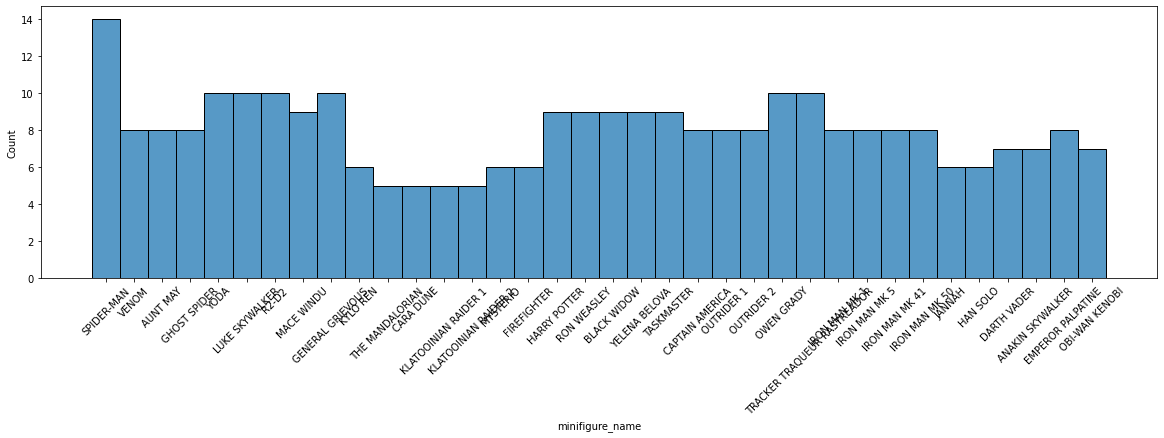

In [106]:
plt.figure(figsize=(20,5))
sns.histplot(df_train['minifigure_name'])
plt.xticks(rotation=45)
plt.show();

In [107]:
def loadImages(df):
    
    base_path = './drive/MyDrive/raw_data'
    loadedImages = []
    for image in df['path']:
        img = PImage.open(f'{base_path}/{image}')
        loadedImages.append(img)
    

    return loadedImages

In [108]:
imgs_train = loadImages(df_train)

In [109]:
len(imgs_train)

287

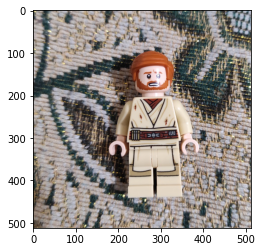

In [110]:
plt.imshow(imgs_train[len(imgs_train)-1])

### Preprocess data (if necessary)

In [111]:
len(df_train.minifigure_name.unique())

36

In [112]:
def preprocess_data(df_train, df_valid):
    '''Loads and preprocesses image data'''

    # Replace with gcp path when using gcp
    base_path = './drive/MyDrive/raw_data'

    # params
    image_size = (256, 256)
    batch_size = 16

    # data transformation
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range = 30,
                                       width_shift_range = 0.3,
                                       height_shift_range = 0.3,
                                       brightness_range=[0.2,1.0],
                                       shear_range = 0.3,
                                       zoom_range = 0.4,
                                       fill_mode='nearest',
                                       vertical_flip=True,
                                       horizontal_flip = True
                                       )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=base_path,
        x_col="path",
        y_col="minifigure_name",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)
    valid_generator = test_datagen.flow_from_dataframe(
        dataframe=df_valid,
        directory=base_path,
        x_col="path",
        y_col="minifigure_name",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size,
        shuffle=False)
    return train_generator, valid_generator

In [113]:
train_generator, valid_generator = preprocess_data(df_train, df_valid)

Found 287 validated image filenames belonging to 36 classes.
Found 74 validated image filenames belonging to 36 classes.


In [114]:
train_generator.batch_size

16

In [115]:
train_generator.image_shape

(256, 256, 3)

## Classification model

### Define initial model architecture 

In [116]:
def init_base_model():
    '''Initializes model'''

    # params - to be finetuned
    input_shape = train_generator.image_shape
    padding = 'same'
    number_of_classes = 36
    opt = optimizers.Adam(learning_rate=0.001)

    # archtitecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding=padding, input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding=padding))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(number_of_classes, activation='softmax'))

    model.compile(optimizer=opt,
                loss="categorical_crossentropy",
                metrics=["accuracy"])
    return model


In [117]:
base_model = init_base_model()

In [118]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 32)      0         
                                                      

### Train initial model

In [119]:
es = callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

base_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    callbacks=[es],
                    verbose=1,
                    epochs=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
18/18 [==============================] - 13s 572ms/step - loss: 3.9475 - accuracy: 0.0348 - val_loss: 3.5815 - val_accuracy: 0.0541
Epoch 2/50
18/18 [==============================] - 8s 449ms/step - loss: 3.5834 - accuracy: 0.0209 - val_loss: 3.5832 - val_accuracy: 0.0270
Epoch 3/50
18/18 [==============================] - 8s 448ms/step - loss: 3.5821 - accuracy: 0.0348 - val_loss: 3.5830 - val_accuracy: 0.0541
Epoch 4/50
18/18 [==============================] - 8s 448ms/step - loss: 3.5819 - accuracy: 0.0488 - val_loss: 3.5828 - val_accuracy: 0.0541
Epoch 5/50
18/18 [==============================] - 8s 448ms/step - loss: 3.5808 - accuracy: 0.0488 - val_loss: 3.5827 - val_accuracy: 0.0541
Epoch 6/50
18/18 [==============================] - 8s 449ms/step - loss: 3.5803 - accuracy: 0.0488 - val_loss: 3.5825 - val_accuracy: 0.0541


### Make prediction based on initial model

In [120]:
df_test.head()

,path,class_id,minifigure_name
0,test/001.jpg,32,JANNAH
1,test/002.jpg,32,JANNAH
2,test/003.jpg,32,JANNAH
3,test/004.jpg,32,JANNAH
4,test/005.jpg,1,SPIDER-MAN


In [121]:
# Get random test image

def get_test_image():
  n = len(df_test)
  random_image = random.randrange(n) # randomly selecting one number.

  test_path = df_test['path'].iloc[random_image] # Picking the image based on randomly selected number.

  # Graphically representing the Image.
  base_path = './drive/MyDrive/raw_data'
  test_image = PImage.open(f'{base_path}/{test_path}')
  plt.imshow(test_image)
  plt.title(df_test['minifigure_name'].iloc[random_image])
  plt.show();

  return test_image

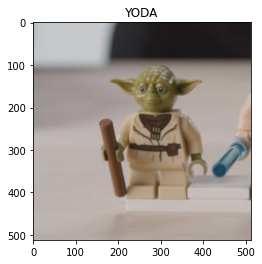

In [122]:
test_image = get_test_image()

In [123]:
def preprocess_test_image(test_image):
    '''Transform test image into vector for model prediction'''

    test_image = test_image.resize((256,256))# reshaping the image size to match training size
    test_image = np.reshape(test_image, (1,256,256,3)) # 1 image, (256, 256) size, 3 representing the RGB type.

    return test_image

In [124]:
test_image = preprocess_test_image(test_image)

In [125]:
test_image.shape

(1, 256, 256, 3)

In [127]:
result = base_model.predict(test_image)
result

array([[2.0841571e-05, 3.9870613e-13, 5.0245607e-03, 4.8416177e-10,
        8.6402829e-12, 6.1010785e-04, 5.0959156e-06, 5.5768504e-07,
        3.5805694e-17, 7.7277502e-07, 2.6452065e-06, 5.0458769e-14,
        1.7711667e-08, 5.4861935e-06, 1.0363036e-08, 2.6969373e-09,
        1.6352916e-09, 3.2466445e-16, 1.4925611e-09, 3.8543189e-11,
        8.8679570e-07, 5.2794235e-08, 3.9994200e-07, 2.3175095e-07,
        2.9657545e-07, 2.3421959e-10, 3.8322678e-04, 6.2446787e-13,
        3.3826853e-07, 9.9387968e-01, 2.0791207e-05, 4.1516065e-05,
        3.4130984e-10, 5.8478306e-10, 2.4576782e-06, 1.0275219e-11]],
      dtype=float32)

In [128]:
prediction_class = result.argmax()
prediction_character = df_test['minifigure_name'].iloc[prediction_class]
prediction_character

'KLATOOINIAN RAIDER 2'

### Save model

In [ ]:
# save model locally
joblib.dump(model, 'model.joblib')

In [ ]:
def store_model_on_gcp(rm=False):
    '''Upload model to Google Cloud Storage'''
    client = storage.Client().bucket(BUCKET_NAME)

    storage_location = f"models/{MODEL_NAME}/{MODEL_VERSION}/{LOCAL_MODEL_NAME}"
    blob = client.blob(storage_location)
    blob.upload_from_filename(LOCAL_MODEL_NAME)
    print(colored(f"=> model.joblib uploaded to bucket {BUCKET_NAME} inside {storage_location}",
                  "green"))
    if rm:
        os.remove('model.joblib')

### Model 1: EfficiencyNet

In [ ]:
!pip install efficientnet

In [130]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.models import Model, load_model

In [131]:
early_stop = callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

In [132]:
def init_model_eff():
    '''Initializes EfficientNet model'''

    # params - to be finetuned
    input_shape = train_generator.image_shape
    number_of_classes = 36

    # archtitecture
    model = EfficientNetB6(weights='imagenet',
                      input_shape=input_shape,
                      include_top=False,
                      pooling='avg')

    x = Dropout(0.3)(model.output)    # adding Droupout layer to the model.
    prediction_efn = Dense(number_of_classes, activation='softmax')(x)
    model = Model(model.input, prediction_efn)

    model.compile(optimizers.Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [133]:
model_eff_2 = init_model_eff()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_eff_2.summary()

In [136]:
model_eff_history = model_eff_2.fit(x=train_generator, 
          validation_data=valid_generator, 
          epochs=50, 
          callbacks=[early_stop])

Epoch 1/50
 1/18 [>.............................] - ETA: 35s - loss: 3.7252 - accuracy: 0.0000e+00

ResourceExhaustedError: ignored

In [ ]:
# save model locally
joblib.dump(model_eff_2, 'model_eff.joblib')

In [ ]:
image = get_test_image()

In [ ]:
test_image = preprocess_test_image(image)
test_image.shape

In [ ]:
results_eff_2 = model_eff.predict(test_image)
results_eff_2

In [ ]:
prediction_class = results_eff_2.argmax()
prediction_character = df_test['minifigure_name'].iloc[prediction_class]
prediction_character